# Demo Helios DAC Connect Computer via USB to Helios DAC

Tested as a notebook in Python 3.11 MacOS using PyCharm <br>
Requires *libHeliosDACAPI.dylib* c library - called by Python via API <br>
Also requires *libusb-1.0.0.dylib* <br>


250513 v1.2 Gaitskell - simple line example, also demoed using oscilloscope attached to Helios<br>
250520 v1.3 Gaitskell - add pseudo spaceship example <br>
250521 v1.4 Gaitskell - upload to github <br>



This version allows experimentation through notebook with what is rendered. <br>
Based initially on demo_loadClibrary.py which is a single script.




## Setup HeliosDAC

In [2]:
import numpy as np
import time

from PyQt5.QtWidgets.QScroller import velocity

In [3]:
# Setup
import ctypes

#Define point structure
class HeliosPoint(ctypes.Structure):
    #_pack_=1
    _fields_ = [
                ('x', ctypes.c_uint16), # x coord 0 to 4k (12 bit)
                ('y', ctypes.c_uint16), # y coord 0 to 4k (12 bit)
                ('r', ctypes.c_uint8),  # red
                ('g', ctypes.c_uint8),  # green
                ('b', ctypes.c_uint8),  # blue
                ('i', ctypes.c_uint8)   # intensity
                ]

In [4]:
# Load and initialize C dynamic library that provides an API to Python
# libHeliosDacAPI.dylib needs to be available in working directory

HeliosLib = ctypes.cdll.LoadLibrary("./libHeliosDacAPI.dylib")
numDevices = HeliosLib.OpenDevices()
if numDevices>0:
    print(f"\nFound {numDevices} Helios DACs")
    # print(f"First Device {}")
else:
    print("\nNo Helios DACs found - cannot proceed")


Found 1 Helios DACs


In [4]:
# HeliosLib.GetName(0 , #ptr to string)  # Need to work out how to get a string back from call to C

## Generate an array of frames
Horizontal Lines that change position vertically - repeated

In [27]:
nPointsPerFrame = 1000 # max 1000, number of points in lines painted in 1 frame

# Create sample frames in array "frames" - doesn't display it yet
nframes = 30
frames = [0 for x in range(nframes)]
frameType = HeliosPoint * nPointsPerFrame  # Array of points
x = 0
y = 0


for i in range(nframes):
    y = round(i * 0xFFF / 30)  # y coordinate same for entire line , jumps with each loop
    frames[i] = frameType()
    for j in range(nPointsPerFrame):
        if (j < nPointsPerFrame//2 ):
            x = round(j * 0xFFF / (nPointsPerFrame//2)) # Full width
        else:
            x = round(0xFFF - ((j - (nPointsPerFrame//2)) * 0xFFF / (nPointsPerFrame//2))) # Full width

        # [i] nframes # of frames
        # [j] nPointsPerFrame points within the frames
        frames[i][j] = HeliosPoint( int(x),int(y) # Position of each point
                                #   ,255,255,255 # RGB = White
                                   ,255,0,128 # RGB = Purple
                                   ,255) # Intensity




# Play "frames" array directly on DAC

nframesDisplay = 150
print(f"Write {nframesDisplay} frames to Helios DACs")
print(f"Using an array with dimensions {len(frames)} frames x {len(frames[0])} points ")
print(f"Will loop again over array if total number of frames to write is greater than array size")

for i in range(nframesDisplay):
# Use i % nframes when selecting from Frame

    for j in range(numDevices):
    # Looping over devices - handles more than one - they all display same

        statusAttempts = 0

        # Make 512 attempts for DAC status to be ready. After that, just give up and try to write the frame anyway
        while (statusAttempts < 512 and HeliosLib.GetStatus(j) != 1):
            statusAttempts += 1

        HeliosLib.WriteFrame( # Send a new frame to HeliosDAC
            j                           # Which device
            , nframes * nPointsPerFrame # pps, points per second
                                        # nframes * number of points in a frame, i.e. size of all frames
                                        # We are asking it to display entire frames "movie" in 1 second
            , 0                         # FLAG=0, waits for current frame to complete, plays repeatedly until new frame loaded
            , ctypes.pointer( frames[i % nframes] )  # We are passing pointer to array of points in single frame
            , nPointsPerFrame  # This is number of points
        )

        if statusAttempts>=512:
            print("Warning: Could not write frame to DAC")

print("\n------------------------------- Finished Writing Frames")



Write 150 frames to Helios DACs
Using an array with dimensions 30 frames x 1000 points 
Will loop again over array if total number of frames to write is greater than array size

------------------------------- Finished Writing Frames


In [7]:
# Stop first device from outputting any frame data
HeliosLib.Stop(0)

1

In [8]:
HeliosLib.GetSupportsHigherResolutions(0) # returns 0 if only 12 bit, 1 if 16 bit

0

In [30]:
HeliosLib.CloseDevices()

1

## Try rendering a single line - randomly selected from previously made array



In [28]:
# Simple Example using Frames Array from previous code

for k in range(100):

    deviceID = 0 # Device #, only one
    i = np.random.randint(low=0, high=nframes, size=None) # , dtype=int , Pick index for a line, randomly from array

    statusAttempts = 0
    # Make 512 attempts for DAC status to be ready. After that, just give up and try to write the frame anyway
    while (statusAttempts < 512 and HeliosLib.GetStatus(j) != 1):
        statusAttempts += 1

    writeStatusFlag = HeliosLib.WriteFrame( #Send the frame
        deviceID                      # Device
        , nframes * nPointsPerFrame   # Why is this 30 frames * number of points in a frame, i.e. all frames
        , 0                           # ???
        , ctypes.pointer( frames[i % nframes] )  # We are passing pointer to array of points
        , nPointsPerFrame             # This is number of points
    )

    print( f"{k:4d} Status: {HeliosLib.GetStatus(j):1d}  WriteStatusFlag: {writeStatusFlag:1d}  StatusAttempts: {statusAttempts:3d}" ) #

    #time.sleep(0.5)


   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   1 Status: 0  WriteStatusFlag: 1  StatusAttempts:   8
   2 Status: 0  WriteStatusFlag: 1  StatusAttempts:  10
   3 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
   4 Status: 0  WriteStatusFlag: 1  StatusAttempts:  12
   5 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
   6 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
   7 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
   8 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
   9 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
  10 Status: 0  WriteStatusFlag: 1  StatusAttempts:  12
  11 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
  12 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
  13 Status: 0  WriteStatusFlag: 1  StatusAttempts:  10
  14 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
  15 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
  16 Status: 0  WriteStatusFlag: 1  StatusAttempts:  11
  17 Status: 0  WriteStatusFlag: 1  StatusAttemp

## Try a Spaceship Sprite

In [29]:
# Useful functions

import numpy as np

def transform_vectors(vectors, angle_radians=0., scale=[1.,1.] , shift=[0.,0.] ):
    """
    Rotates, scales, and shifts an array of 2D vectors.

    Args:
        vectors (numpy.ndarray): Array of 2D vectors, shape (n, 2).
        angle_radians (float): Rotation angle in radians (counter-clockwise).
        scale_x (float): Scaling factor in x-direction.
        scale_y (float): Scaling factor in y-direction.
        shift_x (float): Shift in x-direction.
        shift_y (float): Shift in y-direction.

    Returns:
        numpy.ndarray: Transformed array of 2D vectors, shape (n, 2).
    """

    # angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians), np.cos(angle_radians)]
    ])

    scale_matrix = np.array([
        [scale[0], 0],
        [0, scale[1]]
    ])

    transformed_vectors = vectors.copy()

    for i in range(vectors.shape[0]):
      transformed_vectors[i] = np.dot(scale_matrix, transformed_vectors[i])
      transformed_vectors[i] = np.dot(rotation_matrix, transformed_vectors[i])
      transformed_vectors[i][0] += shift[0]
      transformed_vectors[i][1] += shift[1]

    return transformed_vectors


In [30]:
# 2D Vectors
sprite = np.array( [[0.,0.],[-1.,-1.],[2.,0.],[-1.,1.],[0.,0.]] ) # Simple spacecraft
nPointsPerFrame = len(sprite)
print(f"{nPointsPerFrame}")

5


[[ 0  0]
 [-1 -1]
 [ 2  0]
 [-1  1]
 [ 0  0]]

[[ 0  0]
 [ 1 -6]
 [ 5  8]
 [-6 -1]
 [ 0  0]]


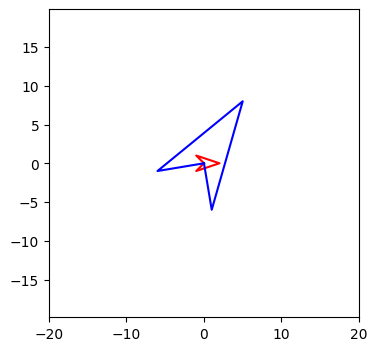

In [31]:
# Demo a rotation
import numpy as np
import matplotlib.pyplot as plt

print( f"{sprite.astype(int)}" )
sprite2 = transform_vectors(sprite,np.pi/3.,scale=[5.,5.])
print( f"\n{ sprite2.astype(int) }" )

plt.figure(1,figsize = (4,4))
plt.plot( *sprite.astype(int).T , 'r' )
plt.plot( *sprite2.astype(int).T , 'b' );
plt.axis('equal');
plt.xlim(-20,20);
plt.ylim(-20,20);

In [91]:
# Simple Example using live generated sprite
deviceID = 0  # Device #, only one

nframes = 100
nPointsPerFrame = len(sprite)
sprites = [0 for x in range(nframes)]
frameType = HeliosPoint * nPointsPerFrame  # Array of points

# Initial random orientation
theta = np.random.uniform(low=0., high=2.*np.pi, size=None)
scale = np.array([1.,1.]) * np.random.randint(low= 290., high= 300., size=None)
shift = np.random.randint(low=2000., high=2100. ,size=(2,))
# vel = np.random.randint(low=20., high=50. ,size=(2,) )
vel = np.array([np.cos(theta),np.sin(theta)]) * np.random.randint(low=10., high=20. ,size=None )

for i in range(nframes):
    sprites[i] = frameType()

    # Change rotation and shift
    shift = shift + vel
    theta = theta + np.random.uniform(low=0., high=2.*np.pi/100., size=None)

    # Make a scaled and rotated sprite with points in the range 0 - 4k
    sprite2 = np.clip(
        transform_vectors( sprite, theta ,scale=scale ,shift=shift ).astype(int)
        , 0 , 4096 ) # Limit the range of coordinates 0 -> 4k

    for j in range(nPointsPerFrame):
        # [i] nframes # of frames
        # [j] nPointsPerFrame points within the frames
        sprites[i][j] = HeliosPoint(
                            int( sprite2[j][0] )
                            , int( sprite2[j][1] ) # Position of each point
                            #, 255, 0, 128 # RGB = Purple,
                            , 255,255,255 # RGB = White
                            , 255  # Intensity
                            )

    # sprite2int = list([sprite2.astype(int),])

    statusAttempts = 0
    # Make 512 attempts for DAC status to be ready. After that, just give up and try to write the frame anyway
    while (statusAttempts < 512 and HeliosLib.GetStatus(deviceID) != 1):
        statusAttempts += 1

    writeStatusFlag = HeliosLib.WriteFrame(  #Send the frame
        deviceID  # Device
        , 1000  # pps
        , 0  # flag
        , ctypes.pointer( sprites[i] )  # We are passing pointer to array of points
        # , ctypes.pointer( frames[0]  )  # We are passing pointer to a list array of points
        , nPointsPerFrame  # This is number of points
    )

    print(
        f"{k:4d} Status: {HeliosLib.GetStatus(deviceID):1d}  WriteStatusFlag: {writeStatusFlag:1d}  StatusAttempts: {statusAttempts:3d}")  #

    time.sleep(0.05)


   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 1  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttempts:   0
   0 Status: 0  WriteStatusFlag: 1  StatusAttemp

In [74]:
shift = np.array([1.,1.]) * np.random.randint(low=2000., high=2100., size=None)
print( shift.shape )

(2,)


In [75]:
vel = np.array([1.,1.]) * np.random.randint(low=0., high=10., size=(2,))

In [76]:
print( vel.shape )

(2,)


In [55]:
int( sprite2[j][0] )

2083

In [66]:
print( np.clip( sprite2 , 0 , 4096 ) )

[[2084 2084]
 [1482 1709]
 [3059 1856]
 [1709 2685]
 [2084 2084]]


In [17]:
np.random.randint(low=1000., high=2000., size=None)

1799

In [20]:
np.random.uniform(low=0., high=2.*np.pi, size=None)

3.2583061851142943

In [42]:
len( sprite2int )

1

In [44]:
len( frames)

30

In [35]:
f = np.array( frames );